#### Following an article I'll do some practice on TimeSeries.
[The article](https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/?utm_source=blog&utm_medium=stockmarketpredictionarticle)

[Another article I used to understand Time-Series](https://towardsdatascience.com/almost-everything-you-need-to-know-about-time-series-860241bdc578)

In [22]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 18, 8

In [23]:
# importing data and printing head
df = pd.read_csv('AirPassengers.csv')
df.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [24]:
#printing dtypes
df.dtypes

Month          object
#Passengers     int64
dtype: object

In [25]:
#The month is dtype object and we want it to be a datetime, so we do it by importing again the dataset with 
#some parameters
df = pd.read_csv('AirPassengers.csv', parse_dates=['Month'], index_col='Month')
df.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [26]:
df.dtypes

#Passengers    int64
dtype: object

In [27]:
#checking the type of the index
df.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name=u'Month', length=144, freq=None)

## How to check Stationarity in a TS?
- A TS is said to be stationary if its statistical properties such as mean, variance remain constant over time.
- TS models work on the assumption that the TS is stationary

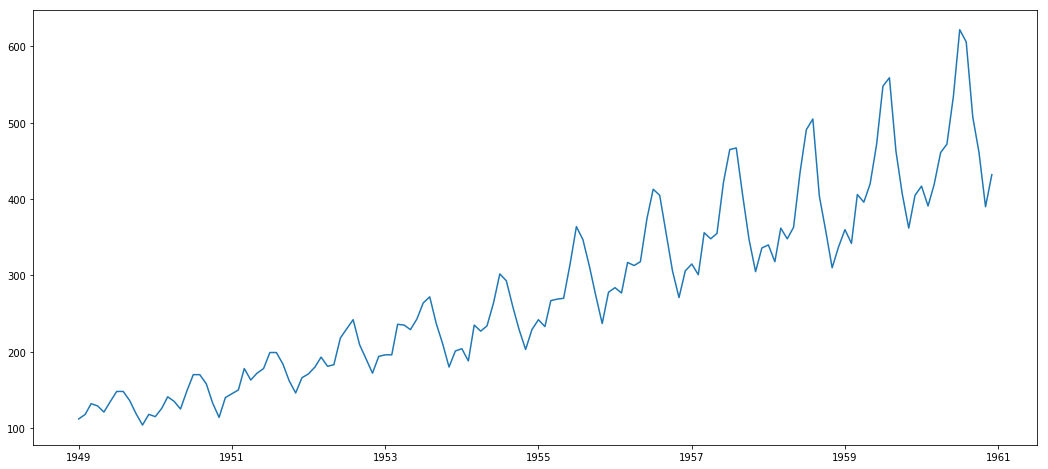

In [28]:
plt.plot(df)

## There are two ways to check stationarity:
- **Rolling stats**: such as SMA.
- **Dickey-Fuller Test**: it's a kind of hypothesis testing. Null hypothesis is the TS not being stationary. The funcition returns th Test Statistic and the Critical Value. We will reject the null hypothesis if the fisrt one is smaller than the second one.

In [29]:
# this function will do it

from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries, column):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best' )
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries[column])
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

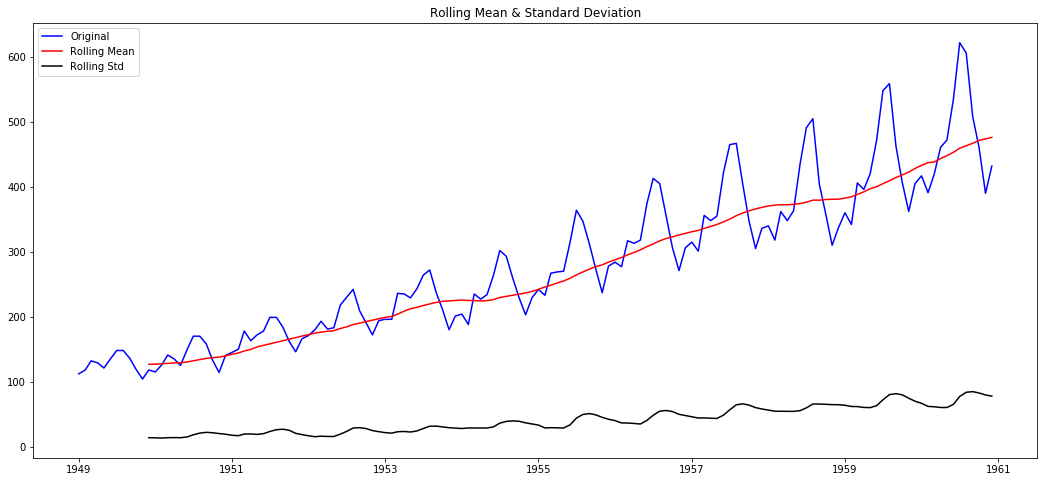

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (5%)             -2.884042
Critical Value (1%)             -3.481682
Critical Value (10%)            -2.578770
dtype: float64


In [30]:
#applying func
test_stationarity(df, '#Passengers')

We can see that the result of the dickey-fuller is not positive so it's not an stationary TS.

## How to make a Time Series Stationary?
There are 2 major reasons behind non-stationaruty of a TS:
1. **Trend** – varying mean over time. For eg, in this case we saw that on average, the number of passengers was growing over time.
2. **Seasonality** – variations at specific time-frames. eg people might have a tendency to buy cars in a particular month because of pay increment or festivals.

The aim is to estimate the trend and seasonality in the series and remove them to get a stationary series. Then statistical forecasting techniques can be implemented. The final step would be to convert the forecasted values into the original scale by applying trend and seasonality constraints back.

### Estimating and eliminating trend
>**Transformation**: to penalize higher values more than smaller values. These can be taking a log, square root, cube root, etc.

Lets take a log transform here for simplicity:

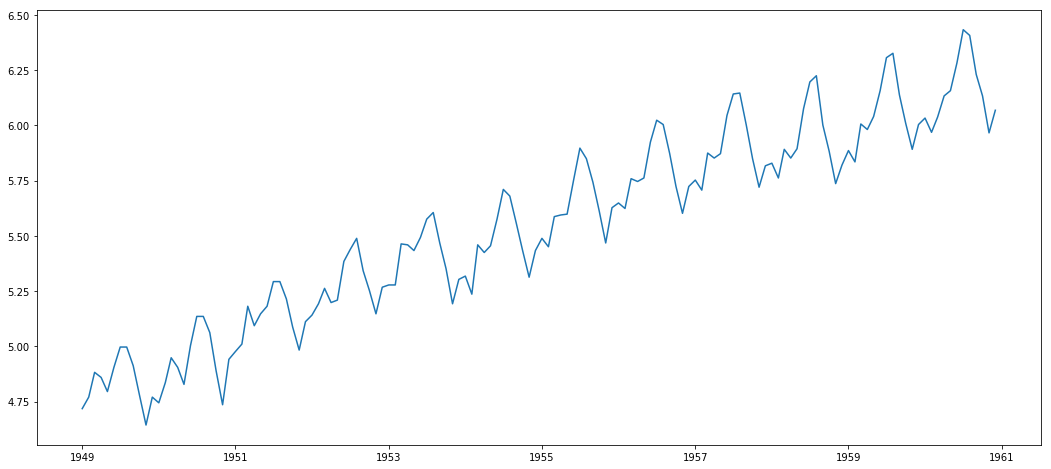

In [31]:
df_log = np.log(df)
plt.plot(df_log)

It is easy to see a forward trend in the data. But it's not very intuitive in more complex TS in presence of noise. So we can use some techniques to estimate or model this trend and then remove it from the series. There can be many ways of doing it and some of most commonly used are:

>- **Aggregation** – taking average for a time period like monthly/weekly averages.
>- **Smoothing** – taking rolling averages.
>- **Polynomial Fitting** – fit a regression model.

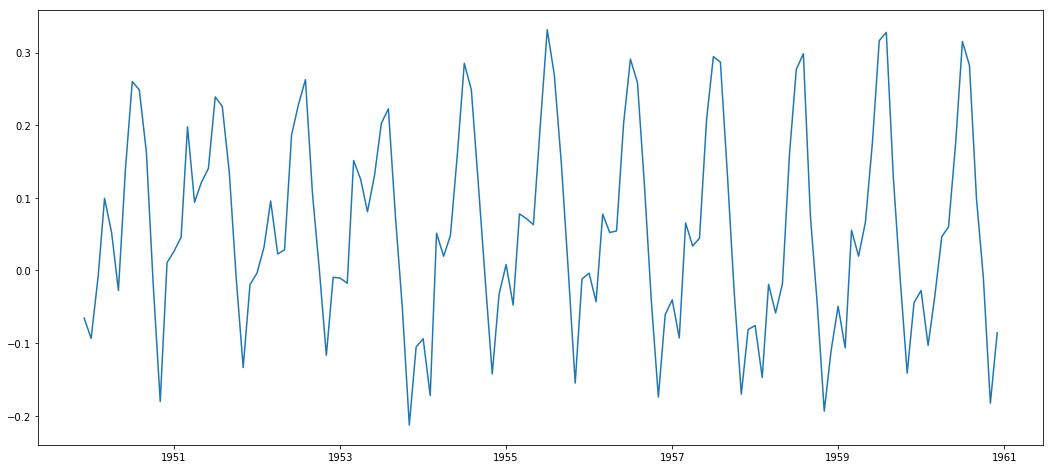

In [32]:
#now we create an average mean and we subtract it from the TS, to eliminate the trend.
roll_mean_log = df_log.rolling(12).mean()
df_log_diff_avg = df_log - roll_mean_log
plt.plot(df_log_diff_avg)

We'll drop the NAN rows created with the roll mean, as there's no value for the 11 first rows.

In [33]:
df_log_diff_avg.dropna(inplace=True)

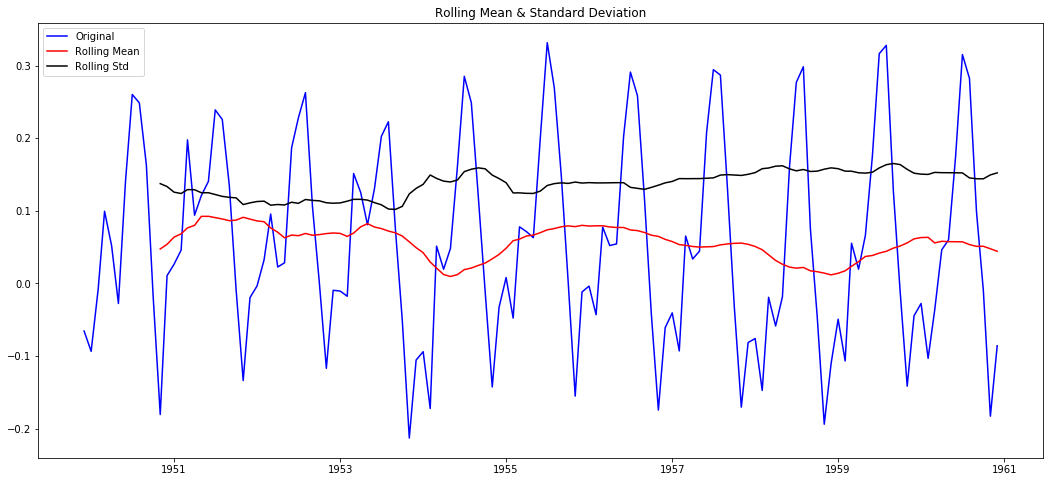

Results of Dickey-Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (5%)             -2.886151
Critical Value (1%)             -3.486535
Critical Value (10%)            -2.579896
dtype: float64


In [34]:
test_stationarity(df_log_diff_avg, '#Passengers')

As the Test Statistic is lower than the critical value 5%, we can say with 95% confidence that the TS is Stationary.

Now we will eliminate trend with the **Weighed Moving Average**, that is more accurate than the previous one.

In [35]:
ewm_log_df = df_log.ewm(halflife=12).mean()

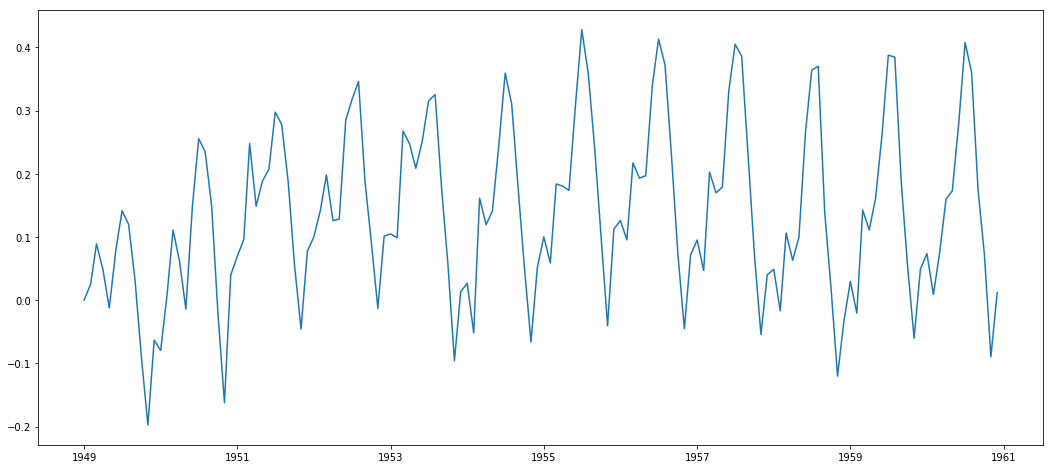

In [36]:
df_diff_ewm_log = df_log - ewm_log_df
df_diff_ewm_log.dropna(inplace=True)
plt.plot(df_diff_ewm_log)

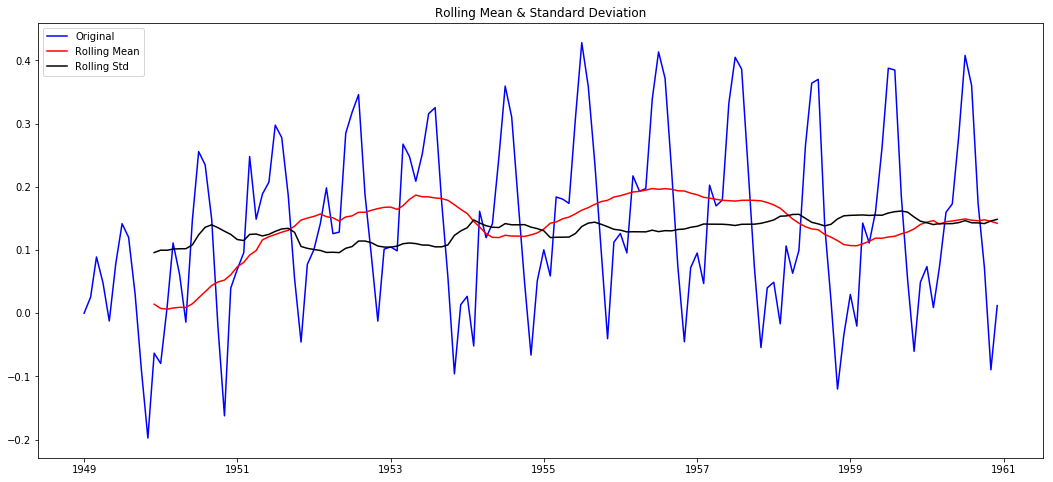

Results of Dickey-Fuller Test:
Test Statistic                  -3.601262
p-value                          0.005737
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (5%)             -2.884042
Critical Value (1%)             -3.481682
Critical Value (10%)            -2.578770
dtype: float64


In [37]:
test_stationarity(df_diff_ewm_log, '#Passengers')

Eliminating the trend with the Weighed Average gives us the best result in terms of stationarity. We can observe in the Dickey-Fuller test that we can say with over 99% confidence that our TS is stationary, because the Test Statistic is under the Critical Value (1%).

# Eliminating trend and seasonality
The simple trend reduction techniques discussed before don’t work in all cases, __particularly the ones with high seasonality.__ Lets discuss two ways of removing trend and seasonality:

> **Differencing** – taking the differece with a particular time lag. In this technique, we take the difference of the observation at a particular instant with that at the previous instant. This mostly works well in improving stationarity. First order differencing can be done in Pandas as:


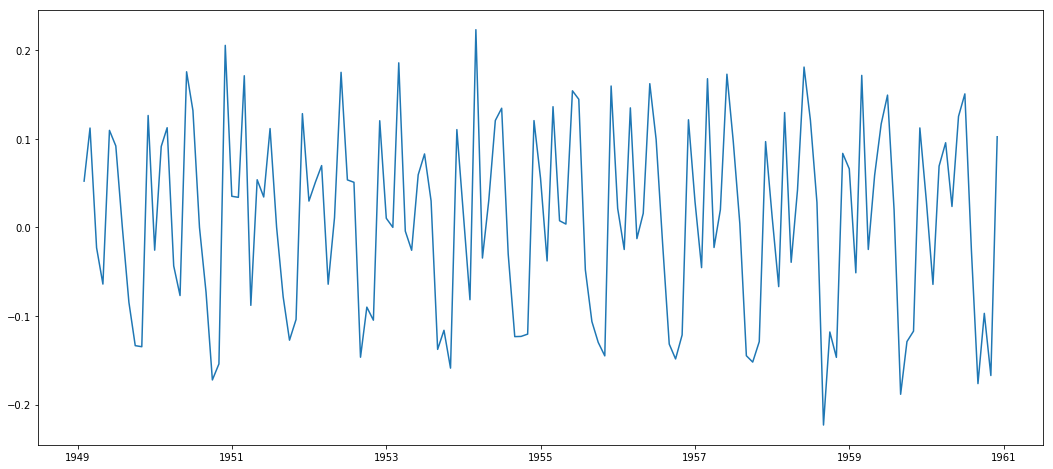

In [38]:
df_log_differencing = df_log - df_log.shift()
plt.plot(df_log_differencing)

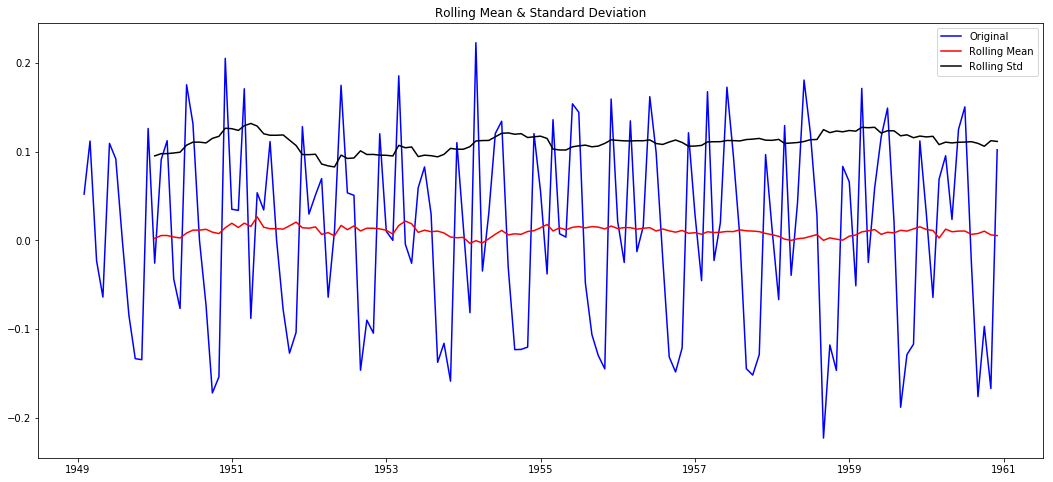

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (5%)             -2.884398
Critical Value (1%)             -3.482501
Critical Value (10%)            -2.578960
dtype: float64


In [39]:
df_log_differencing.dropna(inplace=True)
test_stationarity(df_log_differencing, '#Passengers')

>__Decomposition__ In this approach, trend and seasonality are modeled separately and the remaining part of the series is returned.

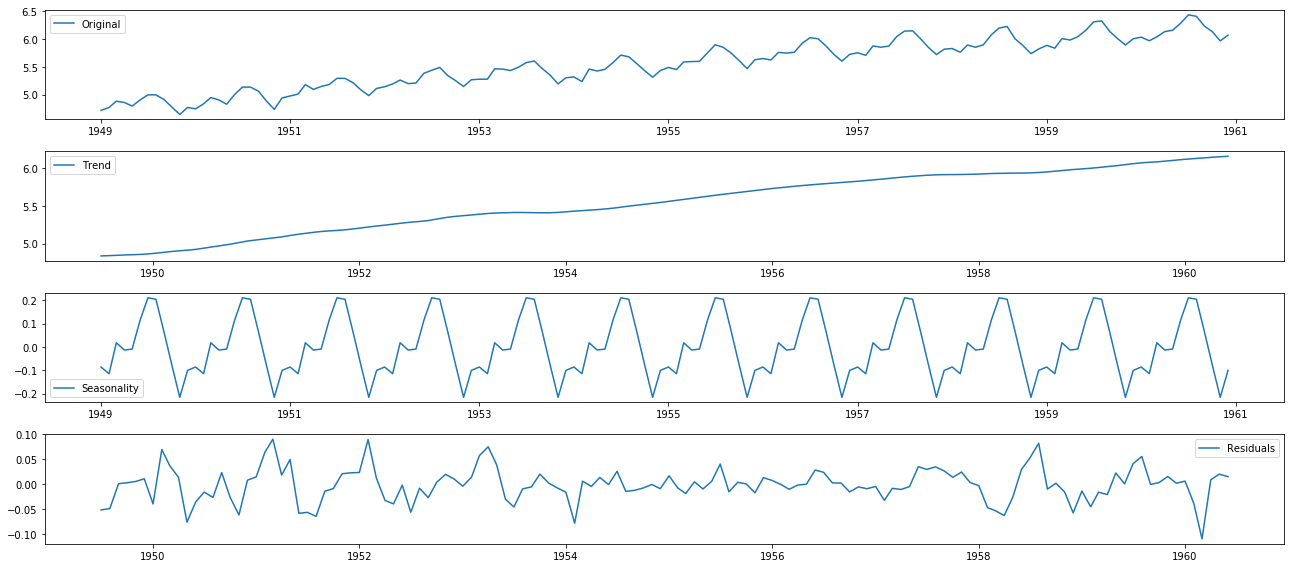

In [40]:
from statsmodels.tsa.seasonal import seasonal_decompose #importing decomposition method
decomposition = seasonal_decompose(df_log) #decomposing with the method

#separing in variables all the results from decomposition.

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

#plotting the results
plt.subplot(411)
plt.plot(df_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

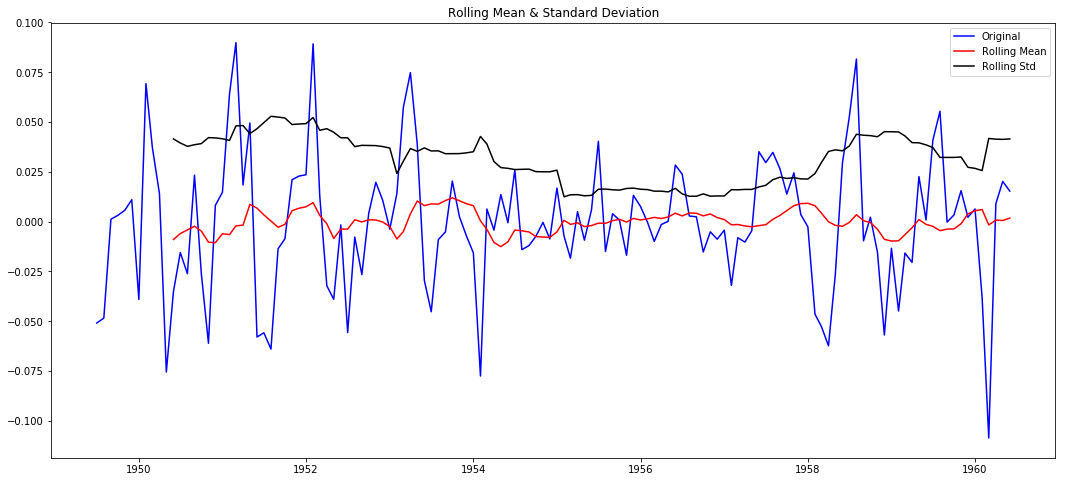

Results of Dickey-Fuller Test:
Test Statistic                -6.332387e+00
p-value                        2.885059e-08
#Lags Used                     9.000000e+00
Number of Observations Used    1.220000e+02
Critical Value (5%)           -2.885538e+00
Critical Value (1%)           -3.485122e+00
Critical Value (10%)          -2.579569e+00
dtype: float64


In [41]:
# residual is the result of the time series after eliminating trend and seasonality with decomposition.
residual.dropna(inplace=True)
test_stationarity(residual, '#Passengers')

The Dickey-Fuller test statistic is significantly lower than the 1% critical value. So this shows that decomposition works great in these cases, TS is very close to stationary. What we don't like about it is the difficulty we'll have later to recover the original out of our analysis.

# Forecasting a Time Series
We will use the one on differenciate, beacuse it is the most known and it is easy to apply the forecast to the original one.

Having performed the trend and seasonality estimation techniques, there can be two situations:

> 1. __A strictly stationary series__ with no dependence among the values. This is the easy case wherein we can model the residuals as white noise. But this is very rare.
> 2. __A series with significant dependence among values__. In this case we need to use some statistical models like ARIMA to forecast the data.

ARIMA stands for Auto-Regressive Integrated Moving Averages. The ARIMA forecasting for a stationary time series is  a linear (like a linear regression) equation. The predictors depend on the parameters (p,d,q) of the ARIMA model:

- __Number of AR (Auto-Regressive) terms (p):__ AR terms are just lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1) tox(t-5).
- __Number of MA (Moving Average) terms (q):__ MA terms are lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1) to e(t-5) where e(i) is the difference between the moving average at ith instant and actual value.
- __Number of Differences (d):__ These are the number of nonseasonal differences, i.e. in this case we took the first order difference. So either we can pass that variable and put d=0 or pass the original variable and put d=1. Both will generate same results.

An importance concern here is how to determine the value of ‘p’ and ‘q’. We use two plots to determine these numbers. Lets discuss them first.

- __Autocorrelation Function (ACF):__ It is a measure of the correlation between the the TS with a lagged version of itself. For instance at lag 5, ACF would compare series at time instant ‘t1’…’t2’ with series at instant ‘t1-5’…’t2-5’ (t1-5 and t2 being end points).
- __Partial Autocorrelation Function (PACF):__ This measures the correlation between the TS with a lagged version of itself but after eliminating the variations already explained by the intervening comparisons. Eg at lag 5, it will check the correlation but remove the effects already explained by lags 1 to 4.

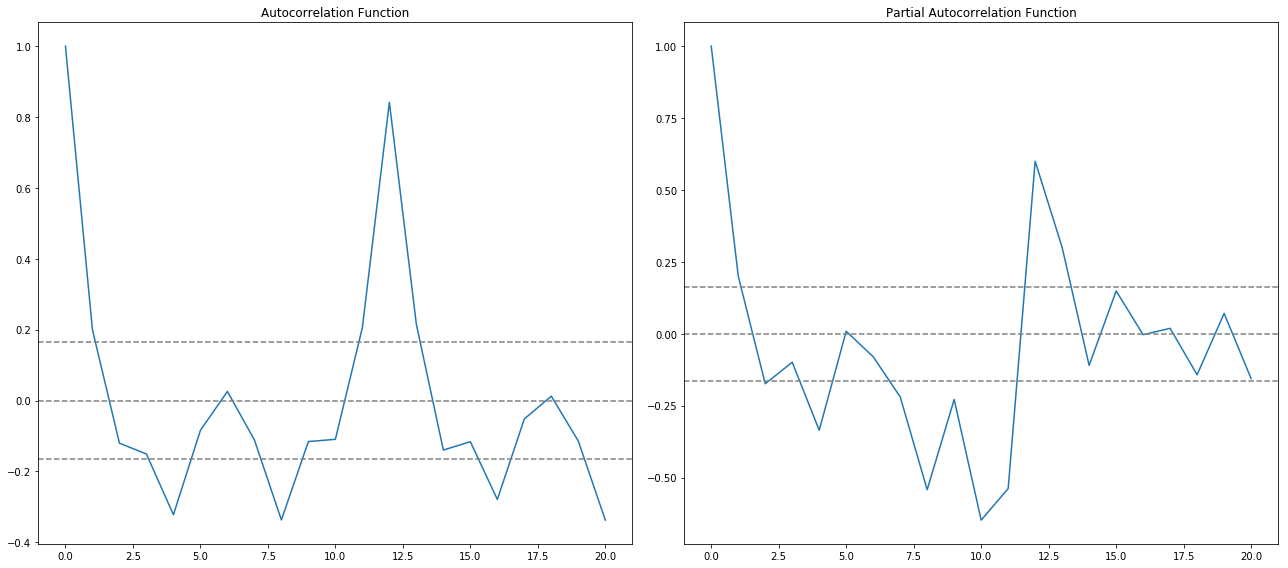

In [52]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(df_log_differencing, nlags=20)
lag_pacf = pacf(df_log_differencing, nlags=20, method='ols')

#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df_log_differencing)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(df_log_differencing)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df_log_differencing)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(df_log_differencing)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In this plot, the two dotted lines on either sides of 0 are the confidence interevals. These can be used to determine the ‘p’ and ‘q’ values as:

- p – The lag value where the PACF chart crosses the upper confidence interval for the first time. If you notice closely, in this case p=2.
- q – The lag value where the ACF chart crosses the upper confidence interval for the first time. If you notice closely, in this case q=2.

### AR Model

/anaconda3/envs/py3/lib/python2.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/anaconda3/envs/py3/lib/python2.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5,1,'RSS: 1.5023')

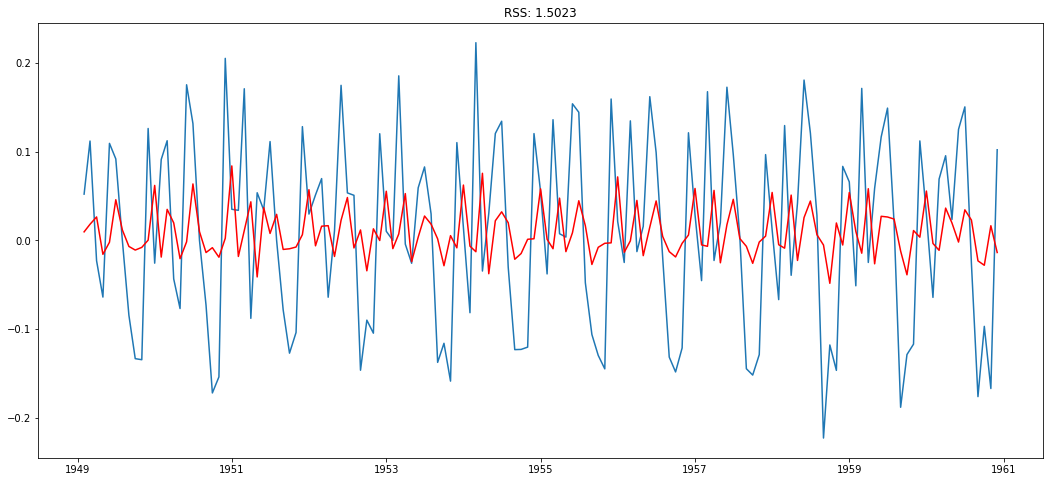

In [68]:
# importing the model
from statsmodels.tsa.arima_model import ARIMA

# creating the model instance with the parameters p, d, q in a tuple

model = ARIMA(df_log, order=(2,1,0))
results_AR = model.fit(disp=-1)

plt.plot(df_log_differencing)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-df_log_differencing['#Passengers'])**2))

# remember to select the column when calculating the rss

## MA model

/anaconda3/envs/py3/lib/python2.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/anaconda3/envs/py3/lib/python2.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5,1,'RSS: 1.4721')

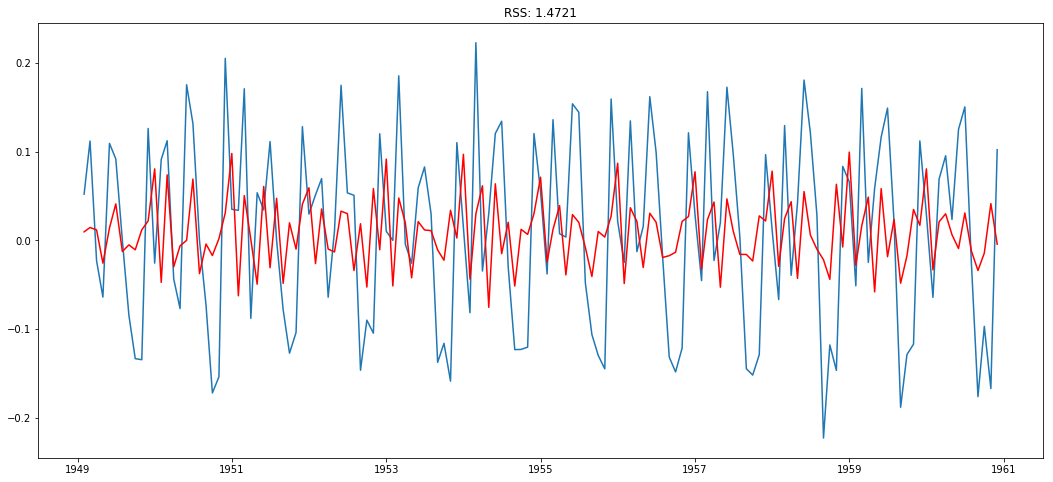

In [69]:
model = ARIMA(df_log, order=(0, 1, 2))  
results_MA = model.fit(disp=-1)  
plt.plot(df_log_differencing)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-df_log_differencing['#Passengers'])**2))

### Combined Model

/anaconda3/envs/py3/lib/python2.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/anaconda3/envs/py3/lib/python2.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5,1,'RSS: 1.0292')

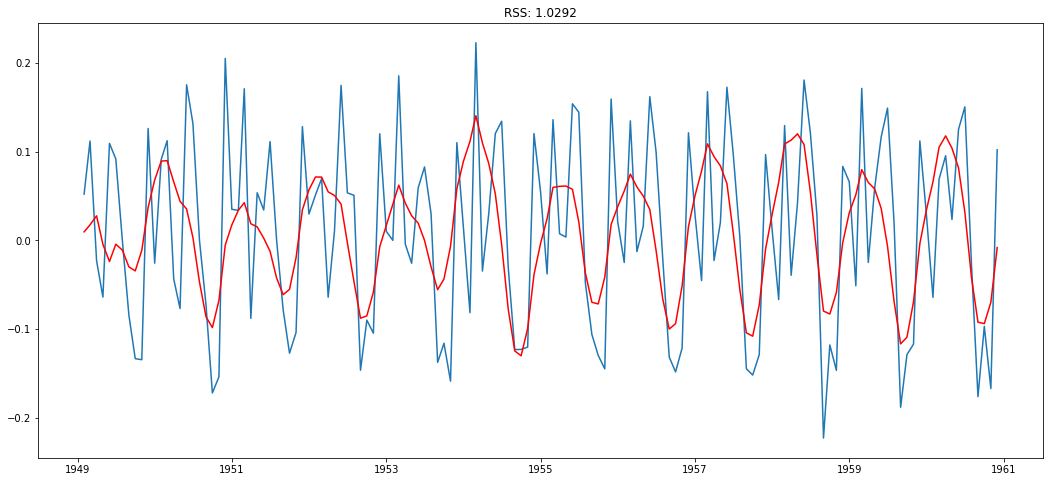

In [72]:
model = ARIMA(df_log, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(df_log_differencing)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-df_log_differencing['#Passengers'])**2))

The lower the RSS the better. RSS stands for Residual Sum of Squares.
__Final step is to scale it back to the original TS__

In [74]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff.head()

Month
1949-02-01    0.009580
1949-03-01    0.017491
1949-04-01    0.027670
1949-05-01   -0.004521
1949-06-01   -0.023890
dtype: float64

Notice that these start from ‘1949-02-01’ and not the first month. Why? This is because we took a lag by 1 and first element doesn’t have anything before it to subtract from. The way to convert the differencing to log scale is to add these differences consecutively to the base number. An easy way to do it is to first determine the cumulative sum at index and then add it to the base number. The cumulative sum can be found as:

In [78]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum.head()

Month
1949-02-01    0.009580
1949-03-01    0.027071
1949-04-01    0.054742
1949-05-01    0.050221
1949-06-01    0.026331
dtype: float64

In [114]:
predictions_ARIMA_log = pd.Series(df_log.iloc() , index=df_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

NotImplementedError: ix is not iterable

Here the first element is base number itself and from thereon the values cumulatively added. Last step is to take the exponent and compare with the original series.

Text(0.5,1,'RMSE: nan')

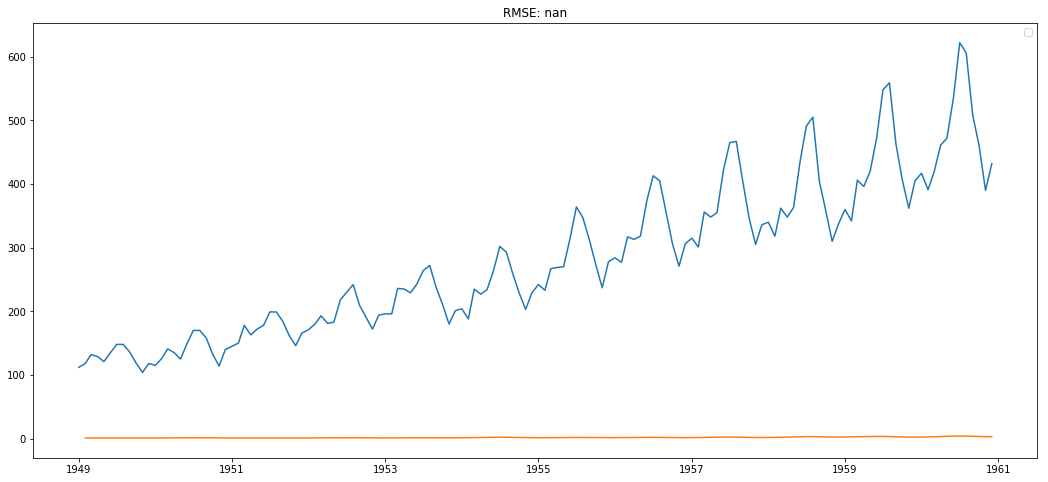

In [110]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(df)
plt.plot(predictions_ARIMA)
plt.legend()
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-df['#Passengers'])**2)/len(df)))